# <center><ins>REIT Portfolio Time Series Analysis<ins/><center/>
## <center>Andrew Cole</center>

#### Import Necessary Libraries

In [45]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg


import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Determine Date Range to be used for API gathering

In [14]:
# Format = (YYYY,MM,DD)

start = datetime(2000,2,1)
end = datetime(2020,1,31)

## <ins>Gather Endogenous Data from AlphaVantage API<ins/>

We are utilizing AlphaVantage's historical financial information via a free API access key which returns a pandas DataFrame. The data is datetime indexed and resampled to monthly average's in order to account for missing weekend values and to reduce noise of the overall series. Finally, to capture the average movement, a Mid Price feature is created by averaging the opening and closing prices. The other features are then dropped from the DataFrame as we will not be working with them. 

In [15]:
FR = web.DataReader('FR', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
FR = FR.copy()
FR.index = pd.to_datetime(FR.index)
FR = FR.resample('MS').mean()
FR['mid'] = (FR['high']+FR['low'])/2
FR.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

The observed mid price movement for the start & end date range is visualized. This observed time series will be utilized for reference during the prediction and validation periods of the analysis.

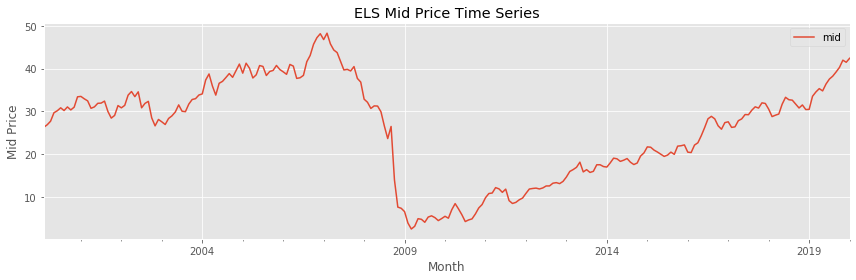

In [16]:
plt.style.use('ggplot')
FR.plot(figsize = (12,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('ELS Mid Price Time Series')
plt.tight_layout()
plt.show();

## <ins>Perform Decomposition of Time Series<ins/>

Now that we have the original observed time series plotted, we must perform a decomposition to further investigate underlying influences on the series.

The decomposition function below will first take the log transformation of the series to make the series more "uniform" over time by removing the upwards trends.

Within the FR REIT, we see a drastic decrease in price right around the time period of The Great Recession of 2008. It is intuitive to think of this event as being an outlier of the rest of the series, but intuition is not enough to justifiably include something in a model. By looking at the residuals plot of the series, we can see that between 2008-2009 the residual distribution strays significantly from the mean. Normally, this would warrant removal of outliers before modeling, however when applying this same method to other REIT series we see that 2008 is **not** always an outlier. For this reason, I have decided to let it remain in the series for continuity purposes across models.

We also take notice that there **is yearly seasonality present** within the time series, which we will account for when selecting the SARIMAX model parameters.

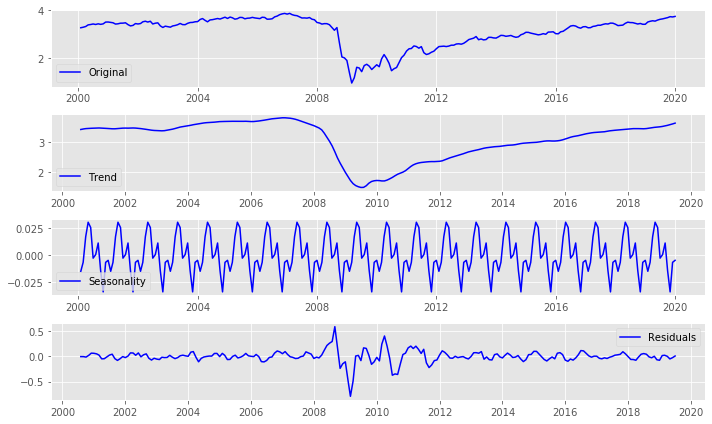

In [17]:
decomposition(FR)

## <ins>Stationarity Testing<ins/>

In order to deal with any remaining trend or seasonality in the series, we will take the first order difference of the series. Differencing will remove the present cyclical seasonality. We must statistically verify that the time series is stationary before we can proceed to modeling. A Dickey-Fuller test is performed (H<sub>0</sub>: The Time Series is **not** stationary) for stationarity. We can see below that the FR series returns a p-value well below the 0.05 critical value for rejecting the null. 

In [18]:
FR_diff = FR.diff(periods = 1).dropna()

In [19]:
dickey_fuller(FR_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 0.006170886001187084


## <ins>Model Optimization<ins/>

We will now use statsmodel's Autocorrelation and Partial Autocorrelation plots to begin to optimize our order parameters for our SARIMAX models. The PACF will provide insight towards selecting the Auto-Regressive parameter order, while the ACF will provide the Moving Average parameter order. We see that the PACF returns three to four autoregressive terms, while the ACF returns approximately four moving average terms. These parameter orders will serve as starting points for our SARIMAX modeling in the following step. However, we will use a combination of AIC/BIC values from the SARIMAX model as well as root mean squared error to determine best fit, and will then adjust the parameters accordingly. In the case of the FR time series, the optimal parameters are 0 auto-regressive terms with 5 moving average terms. We also include the first order of differencing as well as the seasonal order (12) to account for the yearly seasonality of our monthly samples.

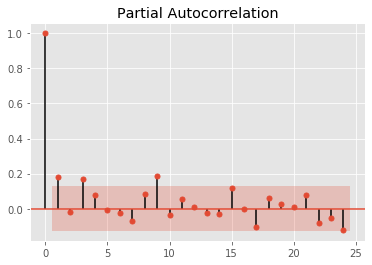

In [20]:
plot_pacf(FR_diff);

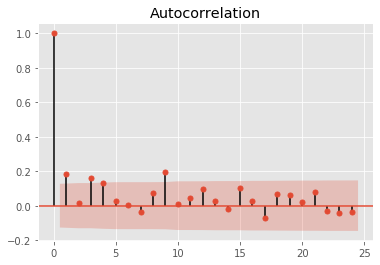

In [21]:
plot_acf(FR_diff);

In [23]:
#optimal parameters for FR series

parameters = (0,1,5)
seasonal_parameters = (0,1,5,12)

## Train Test Split

The FR time series is split into two series: train and test, based off of the datetime index. 

In [24]:
FR_train = FR[:'2017']
FR_test = FR['2018':]

## SARIMAX Model (No Exogenous Variables)

We will first perform this time series model without exogenous variables. This step is primarily meant to assist in optimizing the order parameters, as well as for reference when looking at model performance when compared with the exogenous model. Multiple models were run for optimization and only the best performing model is shown below.

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(0, 1, 5)x(0, 1, 5, 12)   Log Likelihood                -268.161
Date:                            Tue, 11 Feb 2020   AIC                            560.322
Time:                                    16:58:36   BIC                            595.274
Sample:                                02-01-2000   HQIC                           574.526
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0005      0.001      0.792      0.428      -0.001       0.002
ma.L1          0.1706     

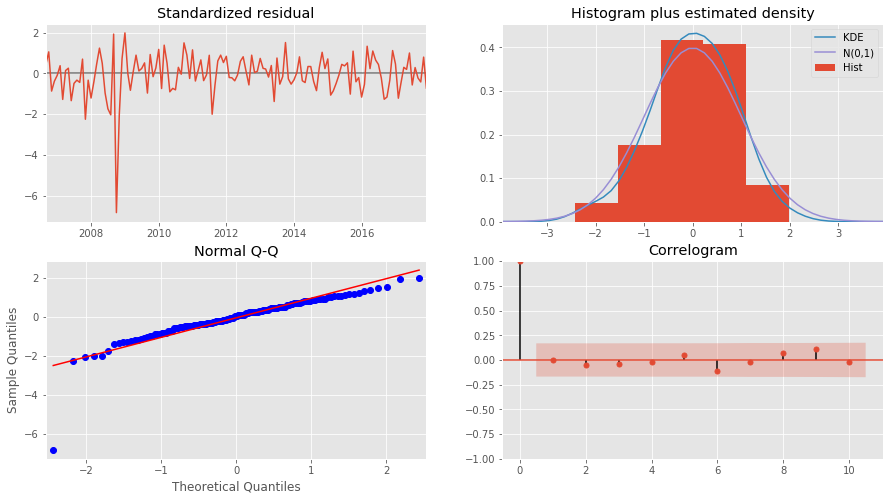

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


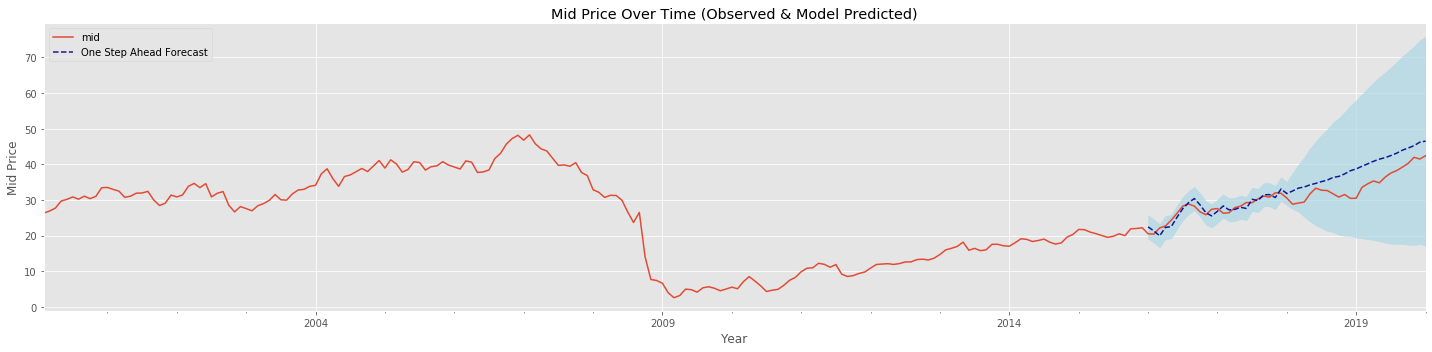

In [29]:
arima_endog(FR_train, FR, parameters, seasonal_parameters)

## <ins>Exogenous Variables<ins/>

Exogenous data gathering and preparation can be found in the EDA.ipynb file. Data is read into a pandas DataFrame below.

In [31]:
FR_rates = pd.read_csv('data/FR_rates.csv', index_col = 'date')

## <ins>Lasso Regression<ins/>

The exogenous variables gathered from FRED (Federal Reserve Economic Database)span across six different financial categories: Interest Rates, Commercial Banking, Exchange Rates, Academic Data, Financial Indicators, and Prices. 55 exogenous variables were obtained. Due to the independent and varying nature of each REIT time series of this portfolio, a lasso regression is necessary to feature select only the most important exogenous variables **per REIT**. The endogenous 'mid' price variable was included as the target variable for the lasso regression.

The R-score of the Lasso Regression is: 0.9878729586083098

usd1mtd156n       -3.197451
mortgage30us      -1.248196
mortgage15us      -2.976175
dcpf3m             4.080561
cpn3m             -0.192908
dcpf1m            -0.888217
aaa               -0.698094
baa               -1.452166
dff                4.316908
flexsc            -0.429874
t10y2y            -0.000000
t10y3m             2.986316
tedrate           -2.349787
t10yff             0.504435
t5yff             -1.699348
tb6smffm           5.316759
usd3mtd156n        1.378603
usd12md156n        0.968437
eur1wkd156n        1.049401
mprime            -0.948908
tb3ms              0.000000
dtb6               0.596743
dgs10              0.549402
dgs3mo            -1.052516
dexuseu            5.408603
dexchus            3.530692
dexusuk           13.180269
dexsius           21.710629
nasdaqcom         -0.005058
willreitind        0.003777
willlrgcap         0.000445
willsmlcap         0.000195
vxdcls            -0.221862
stlfsi          

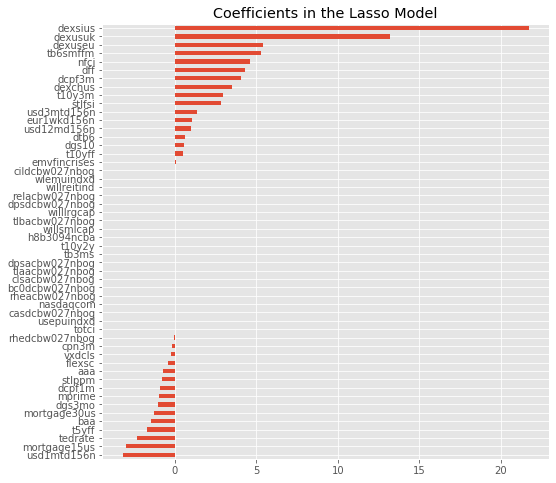

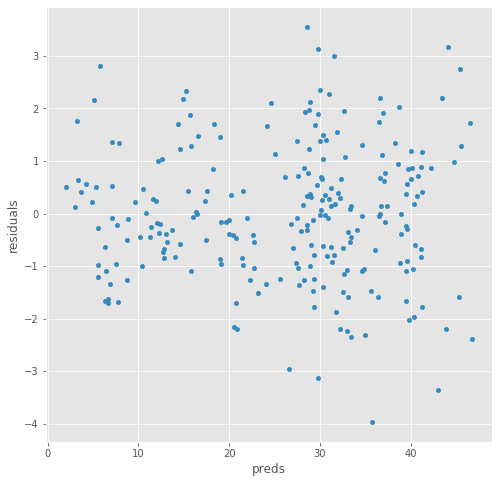

In [32]:
lasso_reg(FR_rates)

### Train-Test Split of exogenous variables
The exogenous variables DataFrame must match the endogenous variable DataFrame in length in order to execute the TS model.

In [36]:
FR_rates_train = FR_rates[:'2018']
FR_rates_test = FR_rates['2018':]

Most important features per the FR time series:

In [34]:
exog_train = FR_rates_train[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [35]:
exog_test = FR_rates_test[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

We then repeat the SARIMAX time series model while including the exogenous variables along with the endogenous mid price data to predict our final model (confidence interval included). 

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(0, 1, 5)x(0, 1, 5, 12)   Log Likelihood                -218.256
Date:                            Tue, 11 Feb 2020   AIC                            498.512
Time:                                    17:22:57   BIC                            588.804
Sample:                                02-01-2000   HQIC                           535.204
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift           1.733e-05      0.001      0.014      0.989      -0.002       0.002
nasdaqcom     

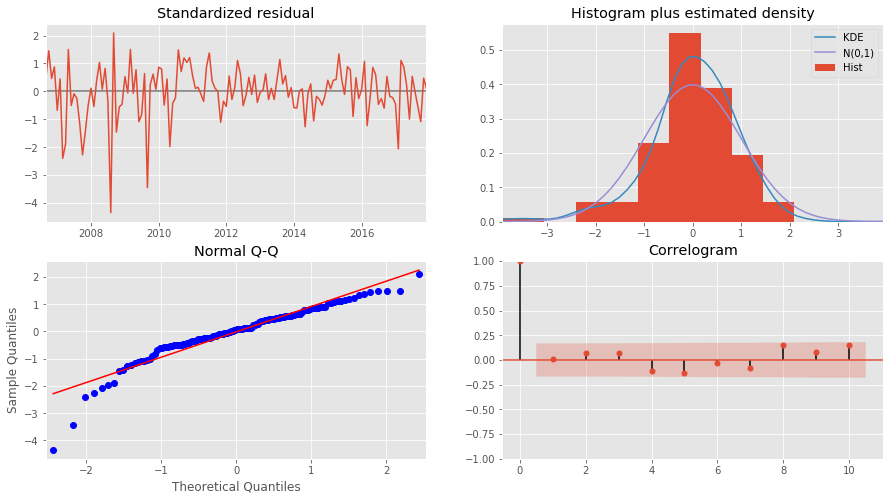

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


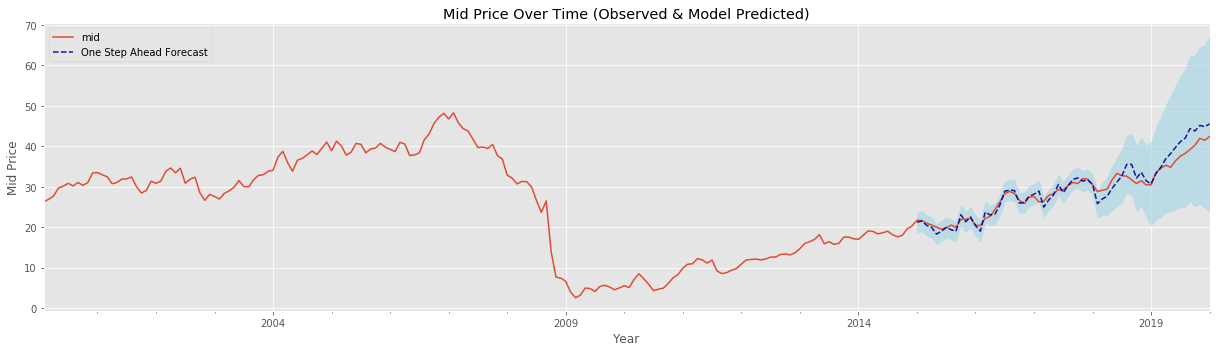

In [41]:
arima_exog(FR_train, FR, parameters, seasonal_parameters, exog_train, exog_test)